## Importing the requisite libraries

In [515]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 9,7

## Basic details of the data

First, let's import the data and have a glimpse of the data

In [516]:
apps = pd.read_csv("./googleplaystore.csv", dtype={'Rating': np.float32})
apps.head(2)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


How many unique categories are present in  each of the categorical variables?

In [517]:
apps[['App','Category','Type','Content Rating','Genres']].nunique()

App               9660
Category            34
Type                 3
Content Rating       6
Genres             120
dtype: int64

Interesting, Type column has 3 unique categories. However, we were expecting just two- Free and Paid. 
Whats going on?

In [518]:
apps['Type'].value_counts()

Free    10039
Paid      800
0           1
Name: Type, dtype: int64

There is a third category- 0 among the Paid and Free apps! Lets check the details.


In [519]:
apps[apps['Type']== '0']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


oops! Appears that the values of the columns just got shifted one place right. Lets fix it.

In [520]:
apps.loc[10472,"App"] = "Life Made WI-Fi"
apps.loc[10472,"Category"] = "Touchscreen Photo Frame"
apps.loc[10472,"Rating"] = "1.9"
apps.loc[10472,"Reviews"] = 19
apps.loc[10472,"Size"] = "3.0M"
apps.loc[10472,"Installs"] = "1,000+"
apps.loc[10472,"Type"] = "Free"
apps.loc[10472,"Price"] = "0"
apps.loc[10472,"Content Rating"] = "Everyone"
apps.loc[10472,"Genres"] = "NaN"
apps.loc[10472,"Last Updated"] = "February 11,2018"
apps.loc[10472,"Current Ver"] = "1.0.19"
apps.loc[10472,"Android Ver"] = "4.0 and up"
apps[apps['App'] == "Life Made WI-Fi"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi,Touchscreen Photo Frame,1.9,19,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11,2018",1.0.19,4.0 and up


Now that we are done fixing it,  Lets check whether we have any duplicate rows.. that is whether the same app was scraped more than once while web scrapping.

In [521]:
apps_name = apps[['App']]#extracting in pandas dataframe not as series

duplicateapps = apps_name[apps_name.duplicated()]

print(duplicateapps['App'].nunique(), 'rows of duplication')



798 rows of duplication



There appears to be 798 duplicate rows consisting of apps scrapped more than once! Lets have a close look after extracting the list of the same.We need to check whether they are different apps with the exact same name or it is truly a case of an app having being scraped more than once.

In [522]:
duplicateapps['App'].unique()[0]

'Quick PDF Scanner + OCR FREE'

In [523]:
apps[apps["App"]=="Quick PDF Scanner + OCR FREE"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
222,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
285,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80804,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up


So the same app has been scrapped more than once in the data.Lets check the top 10 apps that have possibly been duplicated in the data.

In [524]:
duplicateapps['App'].value_counts().head(10)

ROBLOX                                                8
CBS Sports App - Scores, News, Stats & Watch Live     7
Duolingo: Learn Languages Free                        6
ESPN                                                  6
8 Ball Pool                                           6
Candy Crush Saga                                      6
Helix Jump                                            5
Bleacher Report: sports news, scores, & highlights    5
Bowmasters                                            5
Temple Run 2                                          5
Name: App, dtype: int64

In [525]:
# making a bool series of all duplicates
bool_series = apps["App"].duplicated() 

#subset the unique ones
unique_apps = apps[~bool_series]

#Juct check for one app--- whether the suplications have been removed.
print(unique_apps[unique_apps["App"]=="Quick PDF Scanner + OCR FREE"])


print("The number of unique apps --- ", unique_apps['App'].nunique())



                              App  Category Rating Reviews  \
222  Quick PDF Scanner + OCR FREE  BUSINESS    4.2   80805   

                   Size    Installs  Type Price Content Rating    Genres  \
222  Varies with device  5,000,000+  Free     0       Everyone  Business   

          Last Updated         Current Ver   Android Ver  
222  February 26, 2018  Varies with device  4.0.3 and up  
The number of unique apps ---  9660


So we have detected and retained only one instance of each app in the data.We are left with 9660 unique apps. Now we are in a position to perform other cleaning.


We noticed that there are some float columns which have textual contents. So we require to treat the data in a format conducive to graphical representation/ model building.

In [526]:
unique_apps['Size'] = unique_apps['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)

unique_apps['Size'] = unique_apps['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
unique_apps['Size'] = unique_apps['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
unique_apps['Size'] = unique_apps['Size'].apply(lambda x: float(str(x).replace('k', '')) * 1024 if 'k' in str(x) else x)
unique_apps['Size'] = unique_apps['Size'].apply(lambda x: float(x))
unique_apps['Installs'] = unique_apps['Installs'].apply(lambda x : str(x).replace('+', '') if '+' in str(x) else x)
unique_apps['Installs'] = unique_apps['Installs'].apply(lambda x: str(x).replace(',', '') if ',' in str(x) else x)
unique_apps['Installs'] = unique_apps['Installs'].apply(lambda x: float(x))

unique_apps['Price'] = unique_apps['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
unique_apps['Price'] = unique_apps['Price'].apply(lambda x: float(x))

unique_apps['Reviews'] = unique_apps['Reviews'].apply(lambda x: float(x))
unique_apps['Rating'] = unique_apps['Rating'].apply(lambda x: float(x))
unique_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9660 entries, 0 to 10840
Data columns (total 13 columns):
App               9660 non-null object
Category          9660 non-null object
Rating            8197 non-null float64
Reviews           9660 non-null float64
Size              8433 non-null float64
Installs          9660 non-null float64
Type              9659 non-null object
Price             9660 non-null float64
Content Rating    9660 non-null object
Genres            9660 non-null object
Last Updated      9660 non-null object
Current Ver       9652 non-null object
Android Ver       9658 non-null object
dtypes: float64(5), object(8)
memory usage: 1.0+ MB


Now our data is clean, only a few missing data exists. Lets create a copy of the df and make further operations for missing data.

In [527]:
df = unique_apps.copy()

### Missing Values


In [528]:
total = df.isnull().sum().sort_values(ascending=True)
percent = df.isnull().sum()/total
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)

                Total  Percent
Android Ver         2      1.0
App                 0      NaN
Category            0      NaN
Content Rating      0      NaN
Current Ver         8      1.0
Genres              0      NaN
Installs            0      NaN
Last Updated        0      NaN
Price               0      NaN
Rating           1463      1.0
Reviews             0      NaN
Size             1227      1.0
Type                1      1.0


Note that there are many instances missing for 'Rating' Variable. Going forward, we will be predicting the rating, hence we require to check this in further detail.

In [529]:
df[df["Rating"].isna()].head(3)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
23,Mcqueen Coloring pages,ART_AND_DESIGN,NaN,61.0,7.0,100000.0,Free,0.0,Everyone,Art & Design;Action & Adventure,"March 7, 2018",1.0.0,4.1 and up
113,Wrinkles and rejuvenation,BEAUTY,NaN,182.0,5.7,100000.0,Free,0.0,Everyone 10+,Beauty,"September 20, 2017",8.0,3.0 and up
123,Manicure - nail design,BEAUTY,NaN,119.0,3.7,50000.0,Free,0.0,Everyone,Beauty,"July 23, 2018",1.3,4.1 and up


Note that these apps have reviews but the rating is missing. Hwever we know that it is compulsory for a user to share a rating (number of stars) if he wants to review the app.We can't really determine why ratings are missing here. However, it will be interesting to check how many apps have zero Review and missing rating.

In [530]:
df.loc[(df['Reviews'] == 0) & (df['Rating'] == np.nan)]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


So there are no apps that  have zero review and missing rating.

So we just delete all observations where rating is missing, as it is the target variable and imputing some values here might influence our predictions.

In [531]:
df = df[~df['Rating'].isna()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8197 entries, 0 to 10840
Data columns (total 13 columns):
App               8197 non-null object
Category          8197 non-null object
Rating            8197 non-null float64
Reviews           8197 non-null float64
Size              7028 non-null float64
Installs          8197 non-null float64
Type              8197 non-null object
Price             8197 non-null float64
Content Rating    8197 non-null object
Genres            8197 non-null object
Last Updated      8197 non-null object
Current Ver       8193 non-null object
Android Ver       8195 non-null object
dtypes: float64(5), object(8)
memory usage: 896.5+ KB


As is evident, our next problem area is "Size" of the app.Lets try to impute some possible value for the app size instead of deleting around 1000  rows.

In [532]:
df[df['Size'].isna()].head(3) #check

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639.0,NaN,5000000.0,Free,0.0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221.0,NaN,10000000.0,Free,0.0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057.0,NaN,1000000.0,Free,0.0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device


Lets fill up the missing sizes of the app using the mean size of same Category

In [533]:
df['Size'].replace('Varies with device', np.nan, inplace = True ) 
df['Size'].fillna(df.groupby('Category')['Rating'].transform('mean'),inplace = True)


In [534]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8197 entries, 0 to 10840
Data columns (total 13 columns):
App               8197 non-null object
Category          8197 non-null object
Rating            8197 non-null float64
Reviews           8197 non-null float64
Size              8197 non-null float64
Installs          8197 non-null float64
Type              8197 non-null object
Price             8197 non-null float64
Content Rating    8197 non-null object
Genres            8197 non-null object
Last Updated      8197 non-null object
Current Ver       8193 non-null object
Android Ver       8195 non-null object
dtypes: float64(5), object(8)
memory usage: 896.5+ KB


Lets delete current version and android version, as these wont be of much use for prediction purposes.

In [535]:
df.drop(labels = ['Current Ver','Android Ver'], axis = 1, inplace = True)

In [536]:
total = df.isnull().sum().sort_values(ascending=True)
percent = df.isnull().sum()/total
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)
print(df.shape , "---- Final shape of the Data")

                Total  Percent
App                 0      NaN
Category            0      NaN
Rating              0      NaN
Reviews             0      NaN
Size                0      NaN
Installs            0      NaN
Type                0      NaN
Price               0      NaN
Content Rating      0      NaN
Genres              0      NaN
Last Updated        0      NaN
(8197, 11) ---- Final shape of the Data


This is our final cleaned data, with 8197 rows and 11 columns, where we will apply various visualizations to understand the pattern and then apply ML algorithms to predict ratings.

### Popular Categories

In [537]:
print(df['Category'].value_counts().head(10))
print("There are" , len(df['Category'].unique()), "Categories")


FAMILY             1608
GAME                912
TOOLS               718
FINANCE             302
PRODUCTIVITY        301
LIFESTYLE           301
PERSONALIZATION     298
MEDICAL             290
PHOTOGRAPHY         263
BUSINESS            263
Name: Category, dtype: int64
There are 34 Categories


As we can see the most popular Categories are Family, Games and Tools

### Popular Content Rating

In [538]:
print(df['Content Rating'].value_counts().head(10))
print("There are" , len(df['Category'].value_counts()), "Categories")


Everyone           6619
Teen                912
Mature 17+          357
Everyone 10+        305
Adults only 18+       3
Unrated               1
Name: Content Rating, dtype: int64
There are 34 Categories


The Most popular Content Ratings are Everyone which is generic and teen

### Popular Genres

In [539]:
print(df['Genres'].value_counts().head(10))

print("There are" , len(df['Category'].value_counts()), "Categories")


Tools              717
Entertainment      471
Education          429
Finance            302
Productivity       301
Lifestyle          300
Personalization    298
Action             292
Medical            290
Sports             266
Name: Genres, dtype: int64
There are 34 Categories


### Now comes the Queen--- Rating 

Text(0.5, 1.0, 'Distribution of Rating')

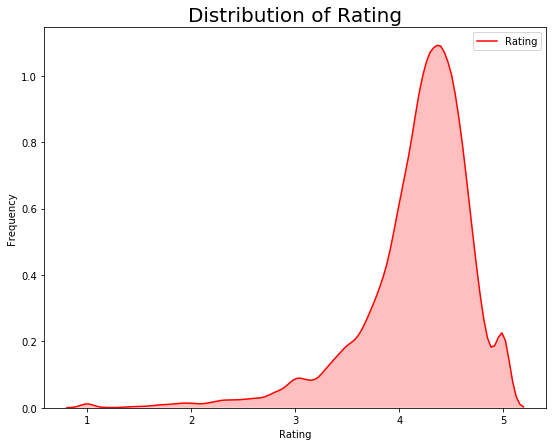

In [540]:

g = sns.kdeplot(df['Rating'], color="Red", shade = True)
g.set_xlabel("Rating")
g.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 20)

On an average, the rating for Google play Store apps is on the higher side- infact around 4.0.
Good luck App Developers!

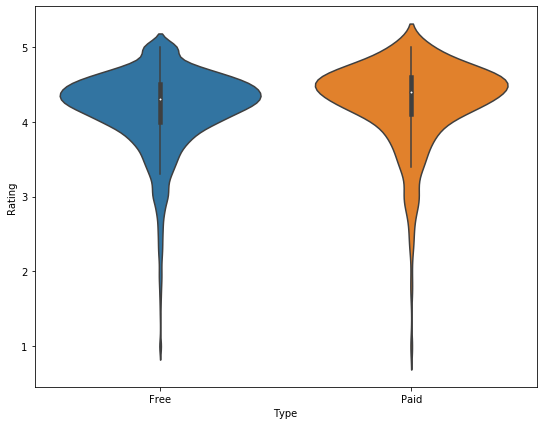

In [541]:
sns.violinplot(x = 'Type', y = 'Rating', data = df)

Appears like Paid apps have a slightly higher average rating.However, interestingly paid apps tapers as it reaches 5 point mark, which means that people would be more generous in rating a free app when it comes to getting a 5 out of 5.

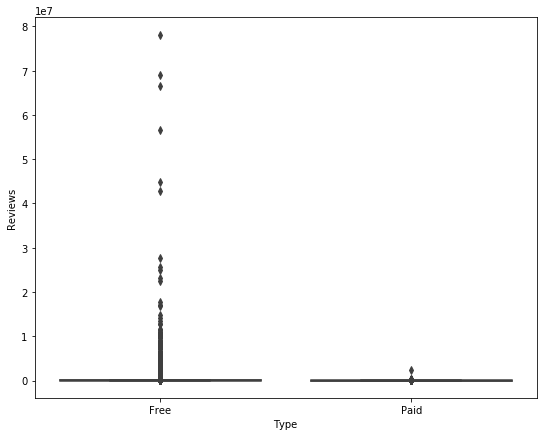

In [542]:
sns.boxplot(x = 'Type', y = 'Reviews', data = df)

Appears like paid have apps have fewer reviews than free apps, which makes sense as people downloading nd using paid apps are far lower than people downloading free apps.

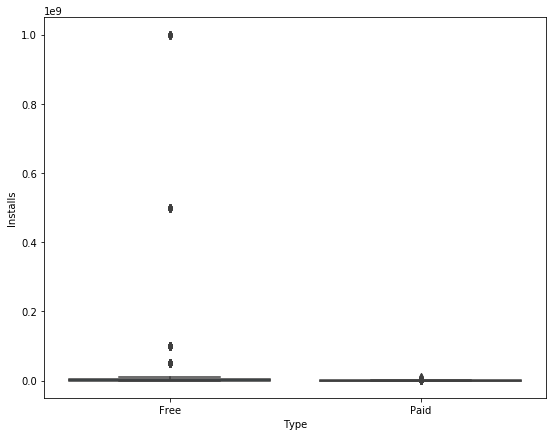

In [543]:
sns.boxplot(x = 'Type', y = 'Installs', data = df)

To confirm our first observation, we also plotted number of installs for paid and free apps.

In [544]:
df.groupby('Type')['Reviews'].mean()


Type
Free    274653.721191
Paid     10919.483444
Name: Reviews, dtype: float64

Obviously, paid apps have lower number of reviews.

How are ratings related to reviews? Lets plot a scatter plot.. We divide our scatter plot in two parts , first with Reviews <2500000, and second with reviews > 2500000

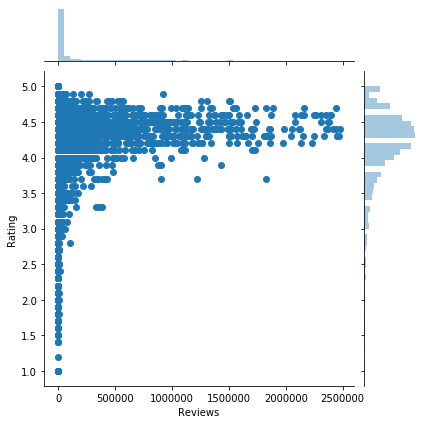

In [545]:
sns.jointplot(x = 'Reviews', y = 'Rating', data = df[df['Reviews'] < 2500000], kind = 'scatter')

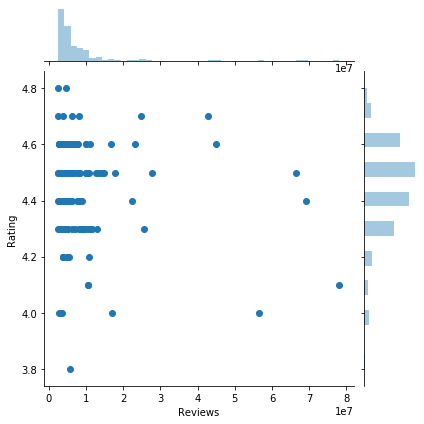

In [546]:
sns.jointplot(x = 'Reviews', y = 'Rating', data = df[df['Reviews'] > 2500000], kind = 'scatter')

As the number of reviews increases, the ratings also increases. Basically the more popular your app is, more is likely to be your rating.
So what are the three most popular apps?

In [547]:
df[df['Reviews'] > 5500000].head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847.0,4.121484,1.000000e+09,Free,0.0,Everyone,Communication,"August 1, 2018"
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316.0,4.121484,1.000000e+09,Free,0.0,Everyone,Communication,"August 3, 2018"
338,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9642995.0,4.121484,1.000000e+09,Free,0.0,Everyone,Communication,"August 1, 2018"


Yeah Expected.Also another point to note--- all the three apps are from Communication category.

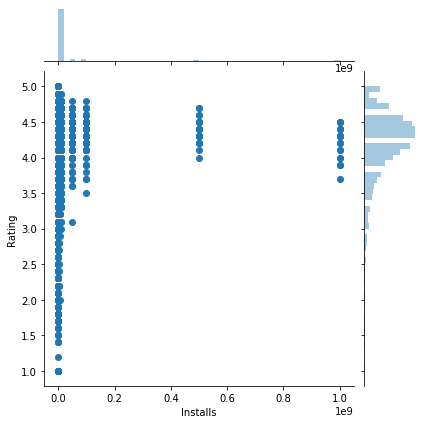

In [548]:
sns.jointplot(x = 'Installs' , y = 'Rating', data = df)

The same can be said about Installs versus Ratings.As people install the app more, the app gets more popular and hence the ratings increase.
Note that we can zoom the right hand section of the graph  to find some additionl insights.

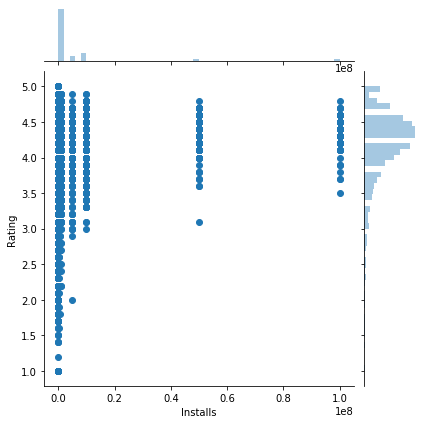

In [549]:
sns.jointplot(x = 'Installs', y = 'Rating', data = df[df['Installs'] < 200000000])

Same conclusion here as well. When installs are more, ratings will also be more.

A question out of curiosity--- Which app is the highest paid app and what is the price of the app?

In [550]:
df[df['Type']=='Paid'].max()

App                      💎 I'm rich
Category                    WEATHER
Rating                            5
Reviews                 2.37656e+06
Size                         988160
Installs                      1e+07
Type                           Paid
Price                           400
Content Rating                 Teen
Genres                      Weather
Last Updated      September 8, 2013
dtype: object

So the most expensive app is 'I'm rich' and its cost is 400 Dollars!

Now we try to find which of the numerical characteristics are correlated with each other. Our best friend is the correlation matrix.

In [551]:
df[['Rating','Reviews','Size','Installs','Price']].corr()

,Rating,Reviews,Size,Installs,Price
Rating,1.000000,0.055087,-0.039237,0.040181,-0.021144
Reviews,0.055087,1.000000,-0.018462,0.624057,-0.007786
Size,-0.039237,-0.018462,1.000000,-0.021978,0.025868
Installs,0.040181,0.624057,-0.021978,1.000000,-0.009651
Price,-0.021144,-0.007786,0.025868,-0.009651,1.000000


So we can see that most of the fetures are uncorrelated, except possibly number of installs and Reviews.
Let's furher explore this.

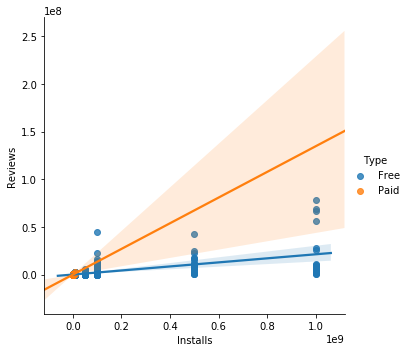

In [552]:
sns.lmplot(x = 'Installs', y = 'Reviews', data = df, hue = 'Type')

Now what we have just explored above are the overall picture--- However this does not throw light on anything non obvious. 
In order to discover something non obvious, let's merge a few price brackets, a few categories and a few genres and then we can check how is rating related to these variables

In [553]:
df.loc[ df['Price'] == 0, 'PriceBand'] = '0 Free'
df.loc[(df['Price'] > 0) & (df['Price'] <= 0.99), 'PriceBand'] = '1 cheap'
df.loc[(df['Price'] > 0.99) & (df['Price'] <= 2.99), 'PriceBand']   = '2 not cheap'
df.loc[(df['Price'] > 2.99) & (df['Price'] <= 4.99), 'PriceBand']   = '3 normal'
df.loc[(df['Price'] > 4.99) & (df['Price'] <= 14.99), 'PriceBand']   = '4 bit expensive'
df.loc[(df['Price'] > 14.99) & (df['Price'] <= 29.99), 'PriceBand']   = '5 too expensive'
df.loc[(df['Price'] > 29.99), 'PriceBand']  = '6 v expensive'


In [554]:
df[['PriceBand', 'Rating']].groupby(['PriceBand'], as_index=False).mean()



,PriceBand,Rating
0,0 Free,4.166074
1,1 cheap,4.298077
2,2 not cheap,4.293671
3,3 normal,4.237838
4,4 bit expensive,4.235897
5,5 too expensive,4.238889
6,6 v expensive,3.910526


We can see that apps at the highest price bracket is the least rated.

Text(0.5, 1, 'Box plot Rating VS PriceBand')

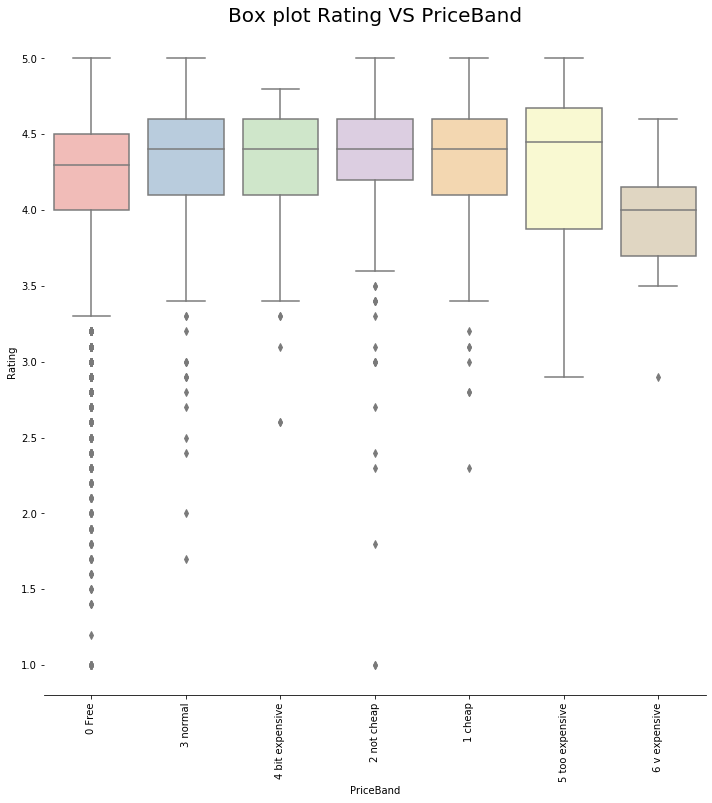

In [555]:
g = sns.catplot(x="PriceBand",y="Rating",data=df, kind="box", height = 10 ,palette = "Pastel1")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Rating")
plt.title('Box plot Rating VS PriceBand',size = 20)



The Free apps has the highest spread of rating, followed by not cheap and normal.As noted earlier most expensive apps are harshly rated.

In [556]:
df['Content Rating'].unique()


array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

Text(0.5, 1, 'Box plot Rating VS Content Rating')

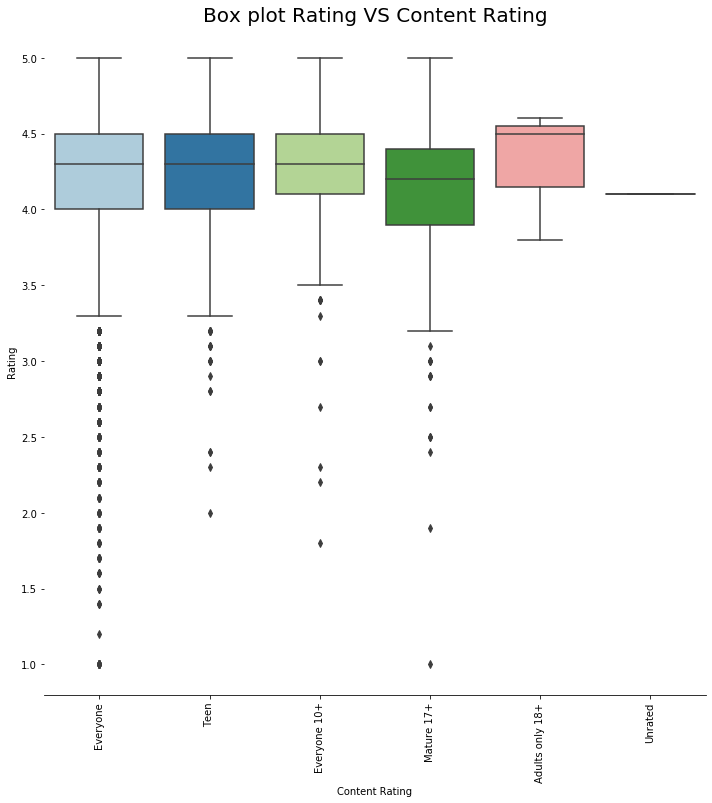

In [557]:
g = sns.catplot(x="Content Rating",y="Rating",data=df, kind="box", height = 10 ,palette = "Paired")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Rating")
plt.title('Box plot Rating VS Content Rating',size = 20)


In [558]:
df[df['Content Rating']=='Unrated']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,PriceBand
8266,DC Universe Online Map,TOOLS,4.1,1186.0,6.4,50000.0,Free,0.0,Unrated,Tools,"February 27, 2012",0 Free


In [559]:
df[df['Content Rating']!='Unrated']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,PriceBand
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.00000,10000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",0 Free
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.00000,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",0 Free
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.70000,5000000.0,Free,0.0,Everyone,Art & Design,"August 1, 2018",0 Free
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25.00000,50000000.0,Free,0.0,Teen,Art & Design,"June 8, 2018",0 Free
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.80000,100000.0,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",0 Free
...,...,...,...,...,...,...,...,...,...,...,...,...
10834,FR Calculator,FAMILY,4.0,7.0,2.60000,500.0,Free,0.0,Everyone,Education,"June 18, 2017",0 Free
10836,Sya9a Maroc - FR,FAMILY,4.5,38.0,53.00000,5000.0,Free,0.0,Everyone,Education,"July 25, 2017",0 Free
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4.0,3.60000,100.0,Free,0.0,Everyone,Education,"July 6, 2018",0 Free
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114.0,4.34497,1000.0,Free,0.0,Mature 17+,Books & Reference,"January 19, 2015",0 Free


In [560]:
print( len(df['Genres'].unique()) , "genres")

print("\n", df['Genres'].unique())



115 genres

 ['Art & Design' 'Art & Design;Pretend Play' 'Art & Design;Creativity'
 'Auto & Vehicles' 'Beauty' 'Books & Reference' 'Business' 'Comics'
 'Comics;Creativity' 'Communication' 'Dating' 'Education;Education'
 'Education' 'Education;Creativity' 'Education;Music & Video'
 'Education;Action & Adventure' 'Education;Pretend Play'
 'Education;Brain Games' 'Entertainment' 'Entertainment;Music & Video'
 'Entertainment;Brain Games' 'Entertainment;Creativity' 'Events' 'Finance'
 'Food & Drink' 'Health & Fitness' 'House & Home' 'Libraries & Demo'
 'Lifestyle' 'Lifestyle;Pretend Play' 'Adventure;Action & Adventure'
 'Arcade' 'Casual' 'Card' 'Casual;Pretend Play' 'Action' 'Strategy'
 'Puzzle' 'Sports' 'Music' 'Word' 'Racing' 'Casual;Creativity'
 'Casual;Action & Adventure' 'Simulation' 'Adventure' 'Board' 'Trivia'
 'Role Playing' 'Simulation;Education' 'Action;Action & Adventure'
 'Casual;Brain Games' 'Simulation;Action & Adventure'
 'Educational;Creativity' 'Puzzle;Brain Games' 'Educati

In [561]:
df['Genres'].value_counts().head(10)

Tools              717
Entertainment      471
Education          429
Finance            302
Productivity       301
Lifestyle          300
Personalization    298
Action             292
Medical            290
Sports             266
Name: Genres, dtype: int64

In [562]:
df['Genres'].value_counts().tail(10)

Casual;Music & Video                   1
Music & Audio;Music & Video            1
Health & Fitness;Action & Adventure    1
Travel & Local;Action & Adventure      1
NaN                                    1
Comics;Creativity                      1
Adventure;Brain Games                  1
Racing;Pretend Play                    1
Art & Design;Pretend Play              1
Parenting;Brain Games                  1
Name: Genres, dtype: int64

In [563]:
df['Genres'] = df['Genres'].str.split(';').str[0]

In [564]:
df.Genres.value_counts().tail(10)


Parenting        50
Card             46
Events           45
Beauty           42
Casino           37
Trivia           28
Word             22
Music            21
NaN               1
Music & Audio     1
Name: Genres, dtype: int64

In [565]:
df[['Genres', 'Rating']].groupby(['Genres'], as_index=False).mean().sort_values('Rating').head(1)

,Genres,Rating
29,NaN,1.9


In [566]:
df[['Genres', 'Rating']].groupby(['Genres'], as_index=False).mean().sort_values('Rating').tail(1)



,Genres,Rating
18,Events,4.435556


Text(0.5, 1, 'Boxenplot of Rating VS Genres')

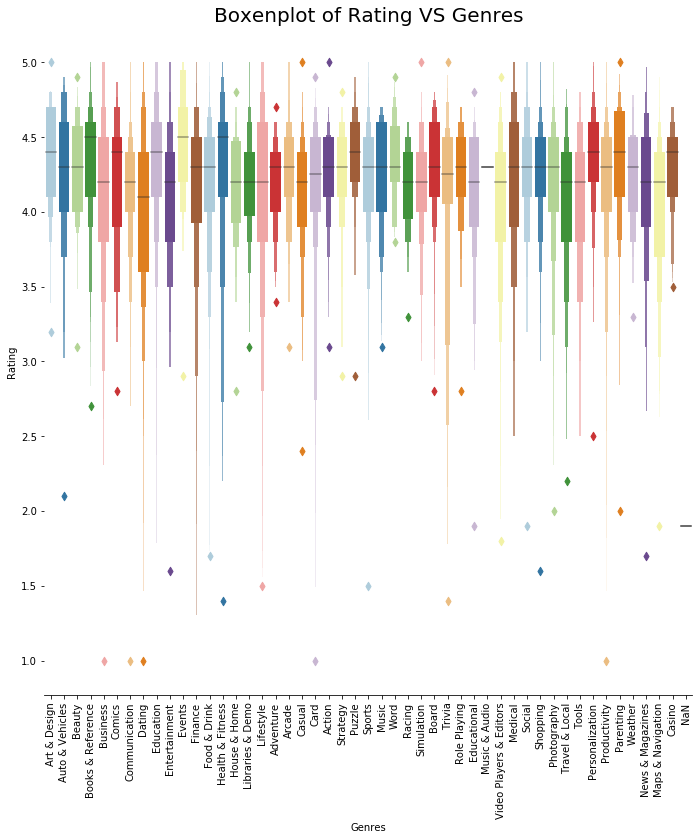

In [567]:
g = sns.catplot(x="Genres",y="Rating",data=df, kind="boxen", height = 10 ,palette = "Paired")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Rating")
plt.title('Boxenplot of Rating VS Genres',size = 20)

### Predictions ---- Lets just first take the numerical columns to predict.

In [568]:
df['Rating'].describe()

count    8197.000000
mean        4.172966
std         0.537179
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

Note that there is a special challenge in predicting this as the output value should be continuous and should lie between 0-5

We will not be applying linear Regression here as as linear regression cannot guarantee output within a specific range say 0-5. Also we saw there is not much correlation among the variables.

Given the method by which decision trees and Random Forest Regressor works, by averaging the Y values for the specific choices of the predictors, it is imperative that this procedure will give us required predictions and is bound to lie within the specific range.
Also KNNRegressor can be thought of another model which can be applied here for prediction purposes.


In [569]:
X = df[['Reviews', 'Size','Installs','Price']]
y = df[['Rating']]

In [570]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [571]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [572]:
y_pred = regressor.predict(X_test)

In [573]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.37051416130542336
MSE: 0.29082870241832354
RMSE: 0.5392853626961551
